# Soft Actor Critic
inspiration: [higgsfield/RL Adventure 2](https://github.com/higgsfield/RL-Adventure-2/blob/master/7.soft%20actor-critic.ipynb)

paper https://arxiv.org/abs/1801.01290

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# comment out if you are not using themes
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/embeddings/ml20_pca128.pkl', 'rb'))
movies_embeddings_tensor, \
key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

# optional: apply tanh -1 1 to actions
with torch.no_grad():
    movies_embeddings_tensor = torch.tanh(movies_embeddings_tensor)

Done!


In [22]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = soft_q_update(step, test_batch, params, learn=False)
    
    gen_actions = debugger.debug_dict['mat']['next_action']
    gen_test_actions = debugger.debug_dict['mat']['test next_action']
    true_actions = np.stack(movie_embeddings_key_dict.values())
    f = plotter.kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)
    writer.add_figure('rec error',f, losses['step'])
    return losses

In [23]:
class StateCritic(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(StateCritic, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [24]:
class SoftQ(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim, init_w=3e-3):
        super(SoftQ, self).__init__()
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [25]:
class StochasticActor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, params):
        super(StochasticActor, self).__init__()
        
        self.log_std_min = params['log_std_min']
        self.log_std_max = params['log_std_max']
        self.drop_layer = nn.Dropout(p=0.5)
        self.normal_dist = torch.distributions.Normal(0, 1)
        
        self.linear1 = nn.Linear(input_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, action_dim)
        self.mean_linear.weight.data.uniform_(-params['mean_initw'],
                                              params['mean_initw'])
        self.mean_linear.bias.data.uniform_(-params['mean_initw'],
                                            params['mean_initw'])
        
        self.log_std_linear = nn.Linear(hidden_size, action_dim)
        self.log_std_linear.weight.data.uniform_(-params['std_initw'],
                                                  params['std_initw'])
        self.log_std_linear.bias.data.uniform_(-params['std_initw'],
                                                params['std_initw'])

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        
        std = log_std.exp()
        z = self.normal_dist.sample().to(cuda)
    
        action = torch.tanh(mean + z * std)
        log_prob = torch.distributions.Normal(mean, std).log_prob(action)
        log_prob -= torch.log(1 - action.pow(2) + epsilon)
        # log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z, mean, log_std

In [26]:
def soft_q_update(step, batch, params, learn=True):
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    
    # --------------------------------------------------------#
    # SoftQ Learning
    expected_softq_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    next_action, log_prob, z, mean, log_std = policy_net.evaluate(state)
    
    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * params['gamma'] * target_value
    q_value_loss = soft_q_criterion(expected_softq_value, next_q_value.detach())
    if learn:
        soft_q_optimizer.zero_grad()
        q_value_loss.backward()
        soft_q_optimizer.step()
        
    # --------------------------------------------------------#
    # StateValue Learning
    expected_next_softq_value = soft_q_net(state, next_action)
    next_value = expected_next_softq_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())
    
    if learn:
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
        soft_update(value_net, target_value_net, params['soft_tau'])
    # --------------------------------------------------------#
    # Policy Learning
    log_prob_target = expected_next_softq_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

    mean_loss = params['mean_lambda'] * mean.pow(2).mean()
    std_loss  = params['std_lambda']  * log_std.pow(2).mean()
    z_loss    = params['z_lambda']    * z.pow(2).sum(0).mean()

    policy_loss += mean_loss + std_loss + z_loss
    
    if learn:
        debugger.log_object('next_action', next_action)
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()
    
    if not learn:
        debugger.log_object('test next_action', next_action)
        writer.add_figure('next_action',
                          recnn.plot.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('expected_softq_value', expected_softq_value, step)
        writer.add_histogram('expected_value', expected_value, step)
        writer.add_histogram('log_prob', log_prob, step)
        writer.add_histogram('z', z, step)
        writer.add_histogram('mean', mean, step)
        writer.add_histogram('log_std', log_std, step)
        writer.add_histogram('target_value', target_value, step)
        writer.add_histogram('next_q_value', next_q_value, step)
        writer.add_histogram('expected_next_softq_value', expected_next_softq_value, step)
        writer.add_histogram('next_value', next_value, step)
        writer.add_histogram('log_prob_target', log_prob_target, step)
        writer.add_histogram('mean_loss', mean_loss, step)
        writer.add_histogram('std_loss', std_loss, step)
        writer.add_histogram('z_loss', z_loss, step)
        writer.close()

    losses = {'value': value_loss.item(),
              'softq': q_value_loss.item(),
              'policy': policy_loss.item(),
              'step'  : step}
    return losses

In [27]:
params = {
    'gamma': 0.99,
    'soft_tau': 0.001,
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    'soft_qvalue_lr': 1e-5,
    
    'critic_weight_init': 1e-1,
    'soft_critic_weight_init': 2e-1,
    'mean_lambda':1e-3,
    'std_lambda':1e-3,
    'z_lambda': 1e-10,
}

stochastic_actor_params = {
    'mean_initw': 1e-1,
    'std_initw': 6e-1,
    'log_std_min':-2,
    'log_std_max':2
}

In [28]:
value_net  = StateCritic(1290, 256, params['critic_weight_init']).to(cuda)
target_value_net = StateCritic(1290, 256).to(cuda)

soft_q_net = SoftQ(1290, 128, 256, params['soft_critic_weight_init']).to(cuda)
policy_net = StochasticActor(1290, 128, 256, stochastic_actor_params).to(cuda)

soft_update(value_net, target_value_net, soft_tau=1.0)

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_optimizer = recnn.optim.RAdam(value_net.parameters(), lr=params['value_lr'])
soft_q_optimizer = recnn.optim.RAdam(soft_q_net.parameters(), lr=params['soft_qvalue_lr'])
policy_optimizer = recnn.optim.RAdam(policy_net.parameters(), lr=params['policy_lr'])


layout = {
    'train': {'value': [], 'softq': [], 'policy': [], 'step': []},
    'test': {'value': [], 'softq': [], 'policy': [], 'step': []}
    }

writer = SummaryWriter(log_dir='../../runs')
debugger = recnn.Debugger(layout, run_tests, writer)
plotter = recnn.Plotter(debugger, [['policy'], ['value', 'softq']],)
torch.autograd.set_detect_anomaly(True)

In [29]:
import warnings
warnings.filterwarnings('ignore')

step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, movies_embeddings_tensor, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 1260


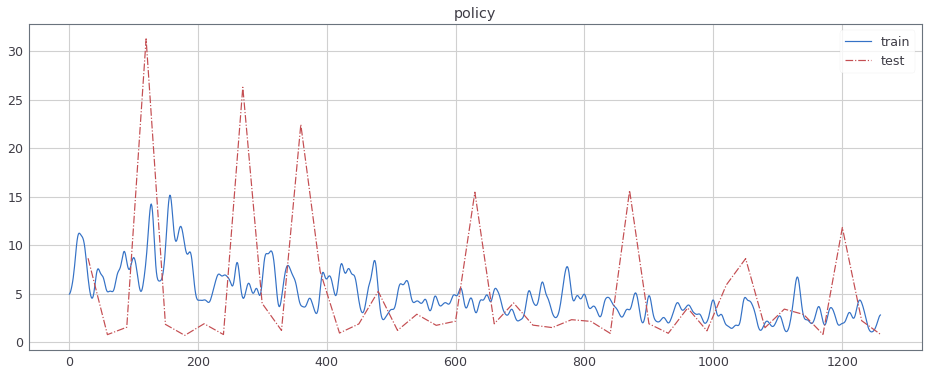

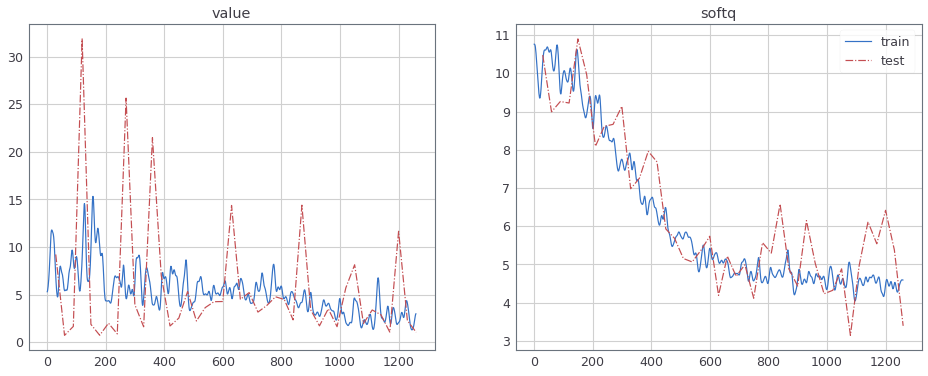

KeyboardInterrupt: 

In [30]:
# --- config ---
plot_every = 30
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = soft_q_update(step, batch, params)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()